# import libraries

In [2]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
import sklearn
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess as lp
import imp
imp.reload(lp)

<module 'LammpsPostProcess' from '/Users/Home/Desktop/Tmp/txt/git/HeaDef/postprocess/LammpsPostProcess.py'>

In [3]:
#matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!

# utility functions

In [4]:
def SetTickLabels(ax, **kwargs):
    fmt='%3.1f'
    if 'xaxis' in kwargs:
        tickLabels = kwargs['xaxis']
        ax.xaxis.set_ticklabels(['$%s$'%i for i in tickLabels])
        ax.xaxis.set_ticks(tickLabels)
    if 'yaxis' in kwargs:
        tickLabels = kwargs['yaxis']
        ax.yaxis.set_ticklabels(['$%s$'%i for i in tickLabels])
        ax.yaxis.set_ticks(tickLabels)
        
def PutMinorTicks(ax, LOGY=None):
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if LOGY:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[2]))
        ymax=np.floor(np.log10(ax.axis()[3]))
        nbin = ymax - ymin
        ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
    
def gaussian_mixture( values, 
                     times,
                     LABELS = False, 
                     PLOT = True):
    thresh = {}
    ratio = {}
#    pdb.set_trace()
    gsFitTotal = 1.0
    for itime in sorted( times ):
    #--- convert data frema to array
        nij = values[itime]
        X=np.log10(nij)
        X=np.array(X).reshape(len(X),1)

        try:
            gm_obj = skm.BayesianGaussianMixture(n_components=2, tol=1e-8, max_iter=10000,
                                                verbose=0, 
    #                                            random_state=32,
    #                                            init_params='random',
                                               )
            gm_obj.fit(X)

            if not gm_obj.converged_:
                continue

            #--- min(\mu0, \mu1) corresponds to trig. mode
            mean0 = gm_obj.means_[0][0]
            mean1 = gm_obj.means_[1][0]
            d     = { 'trigrd':min([mean0,0],[mean1,1])[1], 
                      'backgrd':max([mean0,0],[mean1,1])[1]}
            mean  = { 'trigrd' : gm_obj.means_[d['trigrd']][0],
                      'backgrd': gm_obj.means_[d['backgrd']][0] }
            sigma = { 'trigrd' : gm_obj.covariances_[d['trigrd']][0]**0.5,
                      'backgrd': gm_obj.covariances_[d['backgrd']][0]**0.5 }
            delta = { 'trigrd' : gm_obj.weights_[d['trigrd']],
                      'backgrd': gm_obj.weights_[d['backgrd']] }
    #        print(sigma['backgrd']/mean['backgrd'])
            #--- plot scatter
            nij_red = nij[gm_obj.predict(X)==0]
            nij_blue = nij[gm_obj.predict(X)==1]
            #ratio[itime] =  sigma['backgrd']/mean['backgrd'] #
            ratio[itime] = 1.0 * len(nij_blue) / (len(nij_red)+len(nij_blue))
    #        print(len(nij_red)+len(nij_blue))
    #        prob = np.random.rand(len(X))
    #         list_of_red = prob  <   gm_obj.predict_proba(X)[:, d['trigrd']] #--- assign modes based on the responsibilities \gamma
    #         list_of_blue = prob >= gm_obj.predict_proba(X)[:, d['trigrd']]
    #         nij_red = nij[list_of_red]
    #         nij_blue = nij[list_of_blue]

            #--- plot distributions
            edge_act, hist_act = DistNij(nij,normed=None, nbins_per_decade = 16)

            if PLOT:
                print('itime=%s, ratio=%s'%(itime,ratio[itime]))
                fig = plt.figure(figsize=(4,4))
                ax = fig.add_subplot(111)
    #            ax.set_yscale('log')
    #            ax.set_ylim(0.9,len(nij_red))#1e3)
                #
                ax.plot(edge_act,hist_act,'o',color='black',label='Total')
                #
                xv = edge_act
                ax.plot( xv, 
                        len(X)*(delta['trigrd']*gaussian(xv, mean['trigrd'], sigma['trigrd'])+
                                delta['backgrd']*gaussian(xv, mean['backgrd'], sigma['backgrd']))*(xv[1]-xv[0]), 
                        color='black')
                ax.plot( xv, len(X)*delta['trigrd']*gaussian(xv, mean['trigrd'], sigma['trigrd'])*(xv[1]-xv[0]),color='red')
                ax.plot( xv, len(X)*delta['backgrd']*gaussian(xv, mean['backgrd'], sigma['backgrd'])*(xv[1]-xv[0]),color='C0')
                if LABELS:
                    ax.set_xlabel(r'$log n_{ij}$')
                    ax.set_ylabel(r'$P(log n_{ij})$')
                ax.set_xlim(np.floor(np.min(edge_act)),np.ceil(np.max(edge_act)))
                #
                gsFitTotal = np.c_[ax.get_lines()[1].get_xdata(),ax.get_lines()[1].get_ydata()] #--- return data
            #


            #--- find decision boundary
            mu0,mu1,sigma0,sigma1,delta0,delta1=mean['trigrd'],mean['backgrd'],sigma['trigrd'],sigma['backgrd'],delta['trigrd'],delta['backgrd']
            def f(x): #,:
                return delta0*np.exp(-0.5*((x-mu0)/sigma0)**2)/sigma0 -\
                        delta1*np.exp(-0.5*((x-mu1)/sigma1)**2)/sigma1
            n_th = 0
            try:
                n_th = optimize.bisect(f, mu0-1*sigma0, mu1+1*sigma1)
                if PLOT:
                    ax.plot([n_th,n_th],ax.axis()[2:],'-.r') #--- vertical line
                thresh[itime]=10**n_th
            except:
                traceback.print_exc()
                pass
            if PLOT:
                fig.savefig('distnijGM.png',bbox_inches='tight',dpi=2*75)
                plt.show()

        except:
            traceback.print_exc()
            continue
    #     print gm_obj.predict_proba([[n_th]])
    return thresh, ratio, gsFitTotal

def DistNij(nij,normed=True, nbins_per_decade = 4, **kwargs):
#--- histogram
    nn=np.log10(nij)
    nmin=kwargs['nmin'] if 'nmin' in kwargs else nn.min()
    nmax=kwargs['nmax'] if 'nmax' in kwargs else nn.max()
    bins=np.linspace(nmin,nmax,int(nmax-nmin)*nbins_per_decade)
    hist, edge = np.histogram(nn,bins=bins,normed=normed)
    
    #--- accumulated histogram
    slist=np.array(nn)
    slist.sort()
    N = len(slist)
    d = histogramACCUMLTD( slist.tolist() )
    keys=list(d.keys())
    keys.sort()
    
    xx=[];yy=[]
    for ikey in keys:
        xx.append(d[ikey][0])
        yy.append(d[ikey][2])
    
    # ax2 = ax.twinx()
    # ax2.plot(xx,yy,
    #         linestyle='-', drawstyle='steps-post',color='red',
    #         linewidth=1.0) #--- accumulated
    # #ax2.set_xlim(-7,1)
    # #ax2.set_ylim(0,1200)
    
    # ax2.tick_params(axis='y',colors='red')
    # ax2.set_ylabel('$N(<n_{ij})$',color='red')
    
    return edge[:-1],hist

def valuesDict(d,keys):
    return list(map(d.get,sorted(keys)))


def histogramACCUMLTD( slist ):
    assert type( slist ) == type( [] ), 'arg must be a list. a %s is given!' %( type( slist ) )
    d = {}
    for item in slist:
        try:
            d[ item ] += 1
        except:
            d[ item ] = 1
    keys = list(d.keys())
    keys.sort()

    cdf = 0.0
    xi = min( slist ) - 1.0e-6
    xf = max( slist ) + 1.0e-6
    npoin = len( slist )
    adict = {}
    for ikey, index in zip( keys, range( sys.maxsize ) ):
        adict[ index ] = [ xi, ikey, cdf ]
        cdf += 1.0 * d[ ikey ] # / npoin
        xi = ikey
    adict[ index + 1 ] = [ xi, xf, cdf ]
    return adict

def GetStrain(lmpData, times, time0 ):
    ebulk = {}
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[time0] )
    box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    for itime in times:

        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
        #
        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk[itime] = dx/l1
    return ebulk
        
    
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print('column already included!')
        return False
    return True

        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()
    
def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>1.0]=1.0
        val[val<-1.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    if colorbar:
        fig.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    
    
def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.axes.xaxis.set_visible(False) #--- remove labels
    ax.axes.yaxis.set_visible(False)

    pos = ax.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),
                     #,vmin=-.01, vmax=.01
                    )
    ax.set_xlim(xlim[0]*frac,xlim[1]*frac)
    ax.set_ylim(ylim[0]*frac,ylim[1]*frac)

#    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()
    
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[a[i,j] for j in range(-int(ngrid/2),int(ngrid/2)+ngrid%2)] 
                              for i in range(-int(mgrid/2),int(mgrid/2)+mgrid%2)])

def Get_rc( xdata, ydata, cTOL ):
    try:
#        xc1 = xdata[np.abs(ydata)<cTOL][0] 
        xc1 = xdata[ydata<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 xv,yv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                ):
    (ny,nx,nz) = crltn.shape
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
#         ax.set_xlabel(xstr,fontsize=16)
#         ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
        PutMinorTicks(ax)
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    xdata0 = np.arange(0,(int(n/2)+n%2)) * dx
    ydata0 = val[0,0:(int(n/2)+n%2)]
    #
    xc = Get_rc( xdata0, ydata0, cTOL )
    #
    if PLOT:
        ax.plot( xdata0, ydata0,
                '-o',label=r'$x$',
                markersize=10,
                color='black',
                markerfacecolor='white',
                markeredgecolor=None,
                markevery=int(len(xdata0)/10),
               )       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    xdata = np.arange(0,(int(m/2)+m%2)) * dy
    ydata = val[0:(int(m/2)+m%2),0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,
                '-s', 
                color = 'red',
                label=r'$y$',
                markersize=10,
                markerfacecolor=None,
                markeredgecolor='black',
                markevery=int(len(xdata)/10),
               )
    #--- plot
    if PLOT:
        ax.legend(frameon=False, fontsize=20,handletextpad=.4,handlelength=1)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='red')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
#        ax.plot((xc,xc),ax.axis()[2:],'-.r')
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
        #
        plt.savefig(fileName,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()
    #
    return (xc, yc), (xdata0,ydata0), (xdata,ydata) 


def GetSlice2d( hist, err,
         xv, yv, zv,
         xtol = 2.5,
         z = 0.0):
############################################################
####### Get a 2D slice out off a 3D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx,nz) = hist.shape
    indices = np.all([np.abs(zv-z)>0.0,np.abs(zv-z)<dx],axis=0) #--- filtering based on the given range
    #--- binning in xy
    flist = hist[indices]
    rvect = np.c_[yv[indices],xv[indices]]
    rx,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = xv[indices] ) #--- \sum r_i
    ry,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = yv[indices]) #--- \sum r_i
    error,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = err[indices] ) #--- \sum r_i
    fmean, bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = flist ) #--- 3d histogram
    count, bin_edges = np.histogramdd( rvect, bins = (ny, nx) ) #--- n_i

    count[count==0] = 1
    rx /= count 
    ry /= count 
    fmean /= count
    error /= count
    return rx, ry, fmean, error

def GetSlice1d( hist, err,
         xv, yv,
         xtol = 2.5,
         **kwargs):
############################################################
####### Get a 1D slice out off a 2D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx) = hist.shape
    if 'y' in kwargs:
        y = kwargs['y']
        indices = np.all([np.abs(yv-y)>0.0,np.abs(yv-y)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = xv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = nx, weights = xv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = nx, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = nx ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = nx, weights = flist ) #--- 3d histogram
    elif 'x' in kwargs:
        x = kwargs['x']
        indices = np.all([np.abs(xv-x)>0.0,np.abs(xv-x)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = yv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = ny, weights = yv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = ny, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = ny ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = ny, weights = flist ) #--- 3d histogram
        
    #--- binning in xy

    count[count==0] = 1
    rdist /= count 
    fmean /= count
    error /= count
    return rdist, fmean, error


def PltCrltnFunc1d( crltn, err,
                 xv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 ylim=(-1.0,+1.0),
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn.copy() #--- only xy plane
#    (m,n)=val.shape
    #--- along x 
    xv2 = xv.copy()
    dx = xv2[1] - xv2[0]
    #
    xdata = xv2 #np.arange(0,(n/2+n%2)) * dx
    ydata = val #[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.errorbar( xdata, ydata,yerr = err, fmt='-o',label=r'$x$')       
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
        ax.plot([xc,xc],ax.axis()[2:],'-.',color='black')
        #
#        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return xc


def DrawFrame(ax, alpha_xl,alpha_xr,alpha_yb,alpha_yt,linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
def MultipleFrames( path='', title='', irun = 0, nmax = 10000 ):
    i=0
    append = False
    while i < nmax:
        try:
            sarr0 = np.c_[np.loadtxt('%s%i/Run%s/%s'%(path,i,irun,title))].T
            #        print i,sarr0
            if not append:
                sarr = sarr0.copy()
                append = True
            else:
                sarr = np.concatenate((sarr,sarr0),axis=0)
        except:
            i+=1
    #        traceback.print_exc()
            continue
        i+=1
    return sarr

def MultipleFrames2nd( path='', title='', nrun = 0, ncols=3 ):
    i=0
    append = False
#    pdb.set_trace()
    while i < nrun:
        sarr0 = (np.ones(ncols)*np.nan).reshape((1, ncols))
#        print(sarr0.shape)
        try:
            sarr0 = np.c_[np.loadtxt('%s/Run%s/%s'%(path,i,title))].T
#            print(sarr0.shape)
        except:
#            traceback.print_exc()
            pass
        if not append:
            sarr = sarr0.copy()
            append = True
#            print(i,sarr0)
        else:
#            print(i,sarr0)
            sarr = np.concatenate((sarr,sarr0),axis=0)
        i+=1
    return sarr

def AvalancheSize(strain, Virial):
    d={'t_end':[],'duration':[],'ds':[]}
    kount = 0
    duration = 0
    ds = 0.0
#    counter = 0
    try:
        dtt = strain[1]-strain[0] #TimeSeries[0]['Time'].iloc[1]-TimeSeries[0]['Time'].iloc[0]
        for items,sbulk in list(zip(strain, Virial)): #TimeSeries[isamp].itertuples():
#            sbulk = items[2]
            t = items #items[1]
            #--- ens. average
            if kount == 0:
                a = sbulk
                ta = t
            elif kount == 1:
                b = sbulk
                tb = t
            else:
                c = sbulk
                tc = t
            if kount < 2:
                kount += 1
                init0 = kount + 1
                continue
            sdr = 0.5 * ( c - a ); #--- derivative
#                print(t, sdr)
#            if sdr < 0.0 and counter == 0:
#                continue
            if sdr > 0.0: #--- elastic loading
                init0 = kount + 1; #--- initialize init
            else: #--- avalanche starts!
#                    print(t, sdr)
                ds += sdr #--- increment avalanche size by the stress derivative
                duration += 1 #--- increment duration
            if init0 - kount == 1 and duration != 0: #--- avalanche ends!
                print(duration,ds) #tc-duration*(tb-ta),tc,duration
    #			ax.plot([tc-duration*(tb-ta),tc], [0.0,0.0]
    #                    ,'o')
                d['t_end'].append(tc) 
                d['duration'].append(duration*dtt) 
                d['ds'].append(-ds)
                ds = 0.0 #--- initialize 
                duration = 0
#                counter+=1
    #		if counter == 1:
    #			break
            a = b #--- new assignments
            b = c;
            ta = tb #--- new assignments
            tb = tc;
            kount += 1
    except:
#        traceback.print_exc()
        pass
    if duration != 0: #--- one single avalanche!
        d['t_end'].append(tc) 
        d['duration'].append(duration*dtt) 
        d['ds'].append(-ds)
#    print(duration,ds)
#fig.show()
    df=pd.DataFrame(d)
    df=df[df['ds']!=0.0]
    
    return df

def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None, density=True):
    if not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)
        
    hist, edges = np.histogram(slist,bins=bins,density=density)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    
    hist = hist[count>0]
    edges = edges[:-1][count>0]
    count = count[count>0]
    
    return  hist, edges, hist / count**0.5


# create a definition for the short hyphen
#matplotlib.rcParams["text.latex.preamble"]+= r'\mathchardef\mhyphen="2D'#.append(r'\mathchardef\mhyphen="2D')

class MyLogFormatter(matplotlib.ticker.LogFormatterMathtext):
    def __call__(self, x, pos=None):
        pass
#         # call the original LogFormatter
#         rv = matplotlib.ticker.LogFormatterMathtext.__call__(self, x, pos)

#         # check if we really use TeX
#         if matplotlib.rcParams["text.usetex"]:
#             # if we have the string ^{- there is a negative exponent
#             # where the minus sign is replaced by the short hyphen
#             rv = re.sub(r'\^\{-', r'^{\mhyphen', rv)

#         return rv
    
def makeTickLabels(ax, xdata, ydata, **kargs):
    ylo = kargs['ylo'] if 'ylo' in kargs else 10**np.floor(np.log10(np.min(ydata)))
    yhi = kargs['yhi'] if 'yhi' in kargs else 10**np.ceil(np.log10(np.max(ydata)))
    xlo = kargs['xlo'] if 'xlo' in kargs else 10**np.floor(np.log10(np.min(xdata)))
    xhi = kargs['xhi'] if 'xhi' in kargs else 10**np.ceil(np.log10(np.max(xdata)))
    center = kargs['center'] if 'center' in kargs else True
    MINUS = kargs['MINUS'] if 'MINUS' in kargs else True
    xc = 0.5*np.log10(xhi*xlo)
    yc = 0.5*np.log10(yhi*ylo)
    
    dx = np.log10(xhi/xlo)*0.5
    dy = np.log10(yhi/ylo)*0.5

    if center:
        dx = dy = np.max([dx,dy])
    
    ax.axis(10**np.array([xc-dx,xc+dx,yc-dy,yc+dy]))
    ax.loglog()
    
    ##--- add major xticks
    xmin=np.ceil(np.log10(ax.axis()[0]))
    xmax=np.floor(np.log10(ax.axis()[1]))
    nbin = xmax - xmin
    ax.set_xticks(np.logspace(xmin,xmax,int(nbin)+1))
    
    #--- add major yticks
    ymin=np.ceil(np.log10(ax.axis()[2]))
    ymax=np.floor(np.log10(ax.axis()[3]))
    nbin = ymax - ymin
    ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
    
    #--- put minor bins
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if MINUS:
        ax.xaxis.set_major_formatter(MyLogFormatter()) #--- minus sign too long

    #--- put minor bins y
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if MINUS:
        ax.yaxis.set_major_formatter(MyLogFormatter()) #--- minus sign too long

        
    ax.tick_params(axis='y',left=True, right=True,which='both')
    ax.tick_params(axis='x',bottom=True, top=True,which='both')
    
def GetBinnedAverage( a, y, **kwargs ):
    n=len(a)
    if 'nbins_per_decade' in kwargs:
        nbins = kwargs['nbins_per_decade'] * int( ( np.ceil(np.max(a))-np.floor(np.min(a)) ) )
    if 'nbins' in kwargs:
        nbins = kwargs['nbins']
    
    ysum = np.histogram(a, bins=nbins, weights=y)[0]
    xsum = np.histogram(a, bins=nbins, weights=a)[0]
    xcount = np.histogram(a, bins=nbins)[0]

#    print xsum
#    print xcount
#    assert not np.any(xcount==0)
    #--- remove zero
    xsum = xsum[xcount!=0]
    ysum = ysum[xcount!=0] 
    xcount = xcount[xcount!=0]

    xmean = xsum/xcount
    ymean = ysum/xcount
    return xmean, ymean, xmean / xcount ** 0.5, ymean / xcount ** 0.5

# Parameters

In [5]:
#--- comment out if no parameter is passed as an env. variable
env_vars = !cat .env
for var in env_vars:
    key, value = var.split('=')
    os.environ[key] = value

path = os.environ.get('path') #--- don't comment!
indx = int(os.environ.get('indx'))

ValueError: not enough values to unpack (expected 2, got 1)

In [6]:
#--- comment out parameters if you pass them
#--- by arguments

#
PressFluc = True
#
VorAnl = True
#
Ovitos = True #--- don't change!
#
nevery = 1 #--- postproc. every n times
#
RemoteMachine = True #--- tex issue: don't run corresponding cells
#
mass={1:58.693, # Ni
      2:58.933195, # Co
      3:51.9961 #Cr
     } 

# 'Co', 'Ni', 'Cr', 'Fe', 'Mn'
# AtomicRadius = {2:1.35, # Co
#                 1:1.35, #Ni
#                 3:1.4 #Cr
#                 } #--- https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)

AtomicRadius = {2:1.252, # Co
                1:1.244, #Ni
                3:1.267 #Cr
                } #--- https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-10012-7/MediaObjects/41467_2019_10012_MOESM1_ESM.pdf

#--- lammps output
#path = '/Users/Home/Desktop/Tmp/txt'
#indx=0

#--- lammps dump/data files: ref. state
fileName = '%s/%s'%(path,[
            'DumpFile.xyz',
            ][indx])#--- parse cords

NameError: name 'path' is not defined


# Dump File

In [143]:
#--- dump files
lmpData = lp.ReadDumpFile( fileName ) 
lmpData.GetCords( ncount = sys.maxsize, columns = {'c_1[1]':'sxx','c_1[2]':'syy','c_1[3]':'szz',
                                                   'c_1[4]':'sxy','c_1[5]':'sxz','c_1[6]':'syz'} )


## parse data

In [144]:
itimee=np.sum(list(lmpData.coord_atoms_broken.keys())) #--- only two timesteps:[0,ntime]
atomsRf = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='list') )
atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
    #
box = lp.Box( BoxBounds = lmpData.BoxBounds[itimee] )
box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    
display(pd.DataFrame(atoms.__dict__).head())
pd.DataFrame(atomsRf.__dict__).head()


,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz
0,21.607381,1.774775,-0.124313,1,3,1434000.0,931700.0,1196000.0,-940200.0,324100.0,53220.0
1,1.404975,1.812528,-0.251139,2,2,-14250.0,-618000.0,-467700.0,-201400.0,387800.0,-18250.0
2,-0.196244,1.719720,1.566614,3,2,291600.0,78310.0,124300.0,-120900.0,435600.0,-134500.0
3,21.670101,3.459281,1.618148,4,2,-72520.0,-110400.0,-1222000.0,-34900.0,358700.0,-445100.0
4,-0.276647,21.984528,-0.289166,5,2,57880.0,-69660.0,-7065.0,-570400.0,522500.0,127500.0


,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz
0,21.607381,1.774775,-0.124313,1,3,1434000.0,931700.0,1196000.0,-940200.0,324100.0,53220.0
1,1.404975,1.812528,-0.251139,2,2,-14250.0,-618000.0,-467700.0,-201400.0,387800.0,-18250.0
2,-0.196244,1.719720,1.566614,3,2,291600.0,78310.0,124300.0,-120900.0,435600.0,-134500.0
3,21.670101,3.459281,1.618148,4,2,-72520.0,-110400.0,-1222000.0,-34900.0,358700.0,-445100.0
4,-0.276647,21.984528,-0.289166,5,2,57880.0,-69660.0,-7065.0,-570400.0,522500.0,127500.0


## removed atom

In [145]:
# atom_id=np.sum(atomsRf.id)-np.sum(atoms.id)
# print('atom_id=',atom_id)
# zz=pd.DataFrame(atomsRf.__dict__)[pd.DataFrame(atomsRf.__dict__)['id']==atom_id]['z'].iloc[0]

In [146]:
# PrintOvito( pd.DataFrame(atomsDiff.__dict__), 
#             open( 'strsDiff.xyz','w'), 
#             footer = 'ITIME=%s'%itimee,
#             attr_list=['id','type','x','y','z','sxx' ,'syy' ,'szz' ,'sxy' ,'sxz' ,'syz'] )

# Voronoi Analysis

In [147]:
if VorAnl and Ovitos:
    rad1=AtomicRadius[1]
    rad2=AtomicRadius[2]
    rad3=AtomicRadius[3]
    !ovitos OvitosCna.py $fileName Voronoi.xyz $nevery 3 $rad1 $rad2 $rad3
    
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)

InputFile= /Users/Home/Desktop/Tmp/txt/DumpFile.xyz
num_frames= 2


# Press. Fluc

In [148]:
if PressFluc:
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='series'),
                      rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[itimee]['type'])),
                      AtomicVolume = ovtData.coord_atoms_broken[itimee]['AtomicVolume'].tolist(),
                    )
    #---
    atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='series'),
                      rad = list(map(AtomicRadius.get,lmpData.coord_atoms_broken[0]['type'])),
                      AtomicVolume = ovtData.coord_atoms_broken[0]['AtomicVolume'].tolist(),
                    )

    display(pd.DataFrame(atoms.__dict__).head())
#     ploc=pd.DataFrame(atoms.__dict__)[['sxx','syy','szz']].apply(lambda x: -np.sum(x)/3,axis=1)
#     ploc0=pd.DataFrame(atoms0.__dict__)[['sxx','syy','szz']].apply(lambda x: -np.sum(x)/3,axis=1)    

,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz,AtomicVolume,rad
0,21.607381,1.774775,-0.124313,1,3,1434000.0,931700.0,1196000.0,-940200.0,324100.0,53220.0,11.346564,1.267
1,1.404975,1.812528,-0.251139,2,2,-14250.0,-618000.0,-467700.0,-201400.0,387800.0,-18250.0,10.940500,1.252
2,-0.196244,1.719720,1.566614,3,2,291600.0,78310.0,124300.0,-120900.0,435600.0,-134500.0,11.075769,1.252
3,21.670101,3.459281,1.618148,4,2,-72520.0,-110400.0,-1222000.0,-34900.0,358700.0,-445100.0,10.927197,1.252
4,-0.276647,21.984528,-0.289166,5,2,57880.0,-69660.0,-7065.0,-570400.0,522500.0,127500.0,11.118824,1.252


In [154]:
def StrsDiff(atoms,atomsRf):
    atomsDiff = lp.Atoms( **pd.DataFrame(atoms.__dict__).copy().to_dict(orient='series'))
    atoms0 = lp.Atoms( **pd.DataFrame(atomsRf.__dict__).copy().to_dict(orient='series'))
    for key in ['sxx','syy','szz','sxy','syz','sxz']:
        atomsDiff.__dict__[key] /= atomsDiff['AtomicVolume']
        atoms0.__dict__[key] /= atoms0['AtomicVolume']
#    display(pd.DataFrame(atomsDiff.__dict__))
    df=pd.DataFrame(atoms0.__dict__).set_index('id').loc[atoms.id]
#    pdb.set_trace()
    for key in ['sxx','syy','szz','sxy','syz','sxz','AtomicVolume']:
        atomsDiff.__dict__[key] -= np.array((df[key]).tolist())
#    display(pd.DataFrame(atomsDiff.__dict__))
    return atomsDiff

if PressFluc:
    atomd=StrsDiff(atoms,atoms0) #--- atomd.sxx has units of stress
    #--- filter abs(dv)>0
    atomd = lp.Atoms( **pd.DataFrame(atomd.__dict__)[np.abs(atomd.AtomicVolume)>1.0e-10].to_dict(orient='series'))
    display(pd.DataFrame(atomd.__dict__))

,x,y,z,id,type,sxx,syy,szz,sxy,sxz,syz,AtomicVolume,rad
262,10.079014,12.472829,5.154563,263,1,8.903586,-214.405680,1420.244090,223.290042,-732.452410,-97.367740,-0.000006,1.244
369,5.187124,5.132674,6.848213,370,1,678.764297,1652.793804,1913.981621,241.386050,283.227153,1707.655143,0.007204,1.244
370,5.348991,3.266831,8.564746,371,1,180.275843,630.886535,270.397501,144.197663,135.176170,306.422443,0.000003,1.244
371,3.471416,4.982855,8.657869,372,3,1515.120728,2208.335958,1693.569187,1421.970575,1025.930951,1202.032926,0.005006,1.267
373,8.736702,5.235329,6.777275,374,1,941.338734,2525.241543,3801.034111,308.580560,473.686742,2626.509555,0.009157,1.244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,8.745496,17.050343,19.615637,986,1,160.042340,992.483077,709.839616,46.149981,-130.588722,821.648980,0.005047,1.244
986,10.464633,17.146274,17.789853,988,2,1344.901387,1749.079991,2489.865945,357.097934,19.967292,1247.938564,0.007812,1.252
988,12.323279,17.124351,19.438767,990,3,440.383093,301.231709,733.691837,122.775157,353.562265,183.007619,0.000638,1.267
990,14.009935,17.238836,17.700842,992,3,944.109399,1129.490361,1633.277797,403.269181,631.661113,977.962732,0.004361,1.267


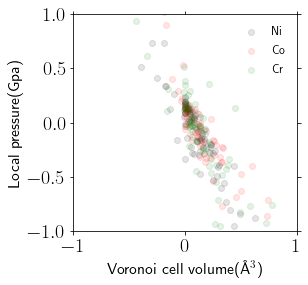

In [155]:
def Zscore(val):
    x=val.copy()
    x -= np.mean(x)
    x /= np.std(x)
    return x
    
def PlotScatter(atomd,**kwargs):
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    if 'xlim' in kwargs:
        ax.axis(kwargs['xlim'])
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #
    #ax.set_ylim(1,1e4)
#    ax.set_xlim(-1,1)
    #
    ax.set_ylabel(r'Local pressure(Gpa)',fontsize=16)
    ax.set_xlabel(r'Voronoi cell volume(\r{A}$^3$)',fontsize=16)

    #PutMinorTicks( ax, LOGY = True)
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    y=np.array(atomd.sxx)+np.array(atomd.syy)+np.array(atomd.szz)
    y *= (-1.0e-4/3.0)
    x = np.array(atomd.AtomicVolume)
    
    cxy=0.0
    if 'zscore' in kwargs and kwargs['zscore']:
        x = Zscore(x)
        y = Zscore(y)
        cxy = np.sum(x*y)/len(x)
    for elm,indxx,col in zip(['Ni','Co','Cr'],[1,2,3],['black','red','green']):
        filtr = np.array(atomd.type) == indxx
        ax.scatter(x[filtr],y[filtr],
                   alpha=.1,c=col,label=elm)#,marker='x')
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    #
    plt.savefig('scatter.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

    return cxy
    
    

if PressFluc and VorAnl:
    cxy = PlotScatter(atomd,
                zscore = True,
                xlim=[-1,1,-1,1],
               )
    np.savetxt('PressVolCrltn.txt',[cxy],header='<p.v>')

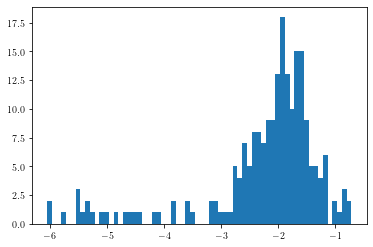

In [160]:
plt.hist(np.log10(atomd.AtomicVolume),bins=64)
plt.show()

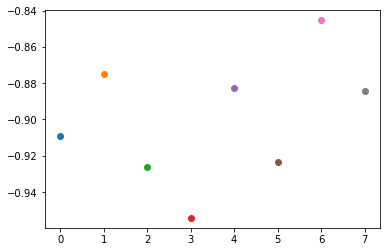

In [10]:
for ifrac in range(8):
    sarr = np.loadtxt('HeaNiCoCrNatom10KTakeOneOutFreezeFract%sRlxd/Run0/PressVolCrltn.txt'%ifrac)
    plt.scatter(ifrac,sarr)
plt.show()

In [133]:
sarr  = MultipleFrames2nd(path='testTakeOneOutRlxd',nrun=32,title='PressVolCrltn.txt',ncols=1).flatten()
np.mean(sarr[~np.isnan( sarr )])


-0.8533457278379443

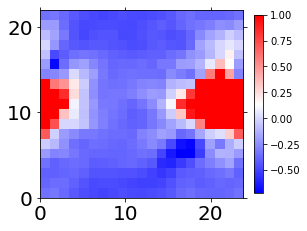

In [24]:
# def Intrp( d2min, box0,times, time0, Plot = None ):
#     #
# #     box0 = lp.Box( BoxBounds = lmpData.BoxBounds[time0] )
# #     box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
#     #
#     d2intrp = {}
#     for itime in times:
# #         d2min = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
#         #
# #         box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
# #         box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
#         #

#         #--- mean dist between atoms 
#         natoms = len( d2min.x ) 
#         CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
#         volume = np.linalg.det( CellVectorOrtho )
#         dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


#         #--- grid tiling mapped box with original size
#         #--- values are interpolated onto this grid
#         (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
#                                                          box0.CellVector, 
#                                                          dmean,
#                                                          margin = 0.0 * dmean )
#         xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

#         #--- expand the original box
#             #--- map to square box
#         mapp = lp.Map( d2min, box ) 
#         mapp.ChangeBasis()
#         mapp.Set( d2min ) #--- atoms: add mapped xyz

#         cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
#         cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
#         d2exp = cptmp.Get()

#         points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
#         values = np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0] #--- corresponding values

#         grid_z = scp_int.griddata(points, values, xi, method='linear')
#         assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

#         #--- make an object
#         d2intrp[ itime ] = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','d2min']).to_dict(orient='list'))

#         if Plot:
#         #--- reshape value
#             nx,ny,nz = len(xlin), len(ylin),len(zlin) 
#             value = np.c_[d2intrp[ itime ].d2min].reshape(((ny,nx,nz)))

#             CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
#             #--- xy plane
#             dz = zlin[-1]-zlin[-2]
#             lz = zlin[-1]-zlin[0]
#             nzz=int(nz*(zz-zlin[0])/lz)
#             val = value[:,:,nzz].copy()
#     #        pdb.set_trace()
        
# #            np.savetxt('d2minBitmap.txt',val)

#             PltBitmap(val, 
#                       xlabel = '', ylabel = '',
#                       xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#                       zscore = True,
#                       frac = 1.0, #--- plot a patch
#                       title = 'd2min.png',
#                       colorbar=True,
#                     )

#     return (xlin, ylin, zlin), (xv, yv, zv), d2intrp
  
# zz=4.8
# junk, junk, d2intrp = Intrp(atomsDiff, box,
#                 times = [0], #list(lmpData.coord_atoms_broken.keys()),
#                 time0 =0,
#                 Plot = True,
#                )